In [7]:
import csv 
import numpy as np
import pandas as pd
import sys
#sys.path.append('/home/lucas/Documents/Log_Analysis/Battery')
sys.path.append('/Users/Lucas/Documents/Travail/Yuneec/LogAnalysis')
sys.path.append('/Users/Lucas/Documents/Travail/Yuneec/LogAnalysis/Battery')
from battery import OCVcurve, Thevenin
import analog
from scipy.interpolate import interp1d as interp1d
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

### Import the equivalent circuit parameters

In [8]:
ECparams = pd.read_csv('ECparams.csv')
R0 = float(ECparams['R0'])
R0 = 0.008
R1 = float(ECparams['R1'])
C1 = float(ECparams['C1'])

<IPython.core.display.Javascript object>


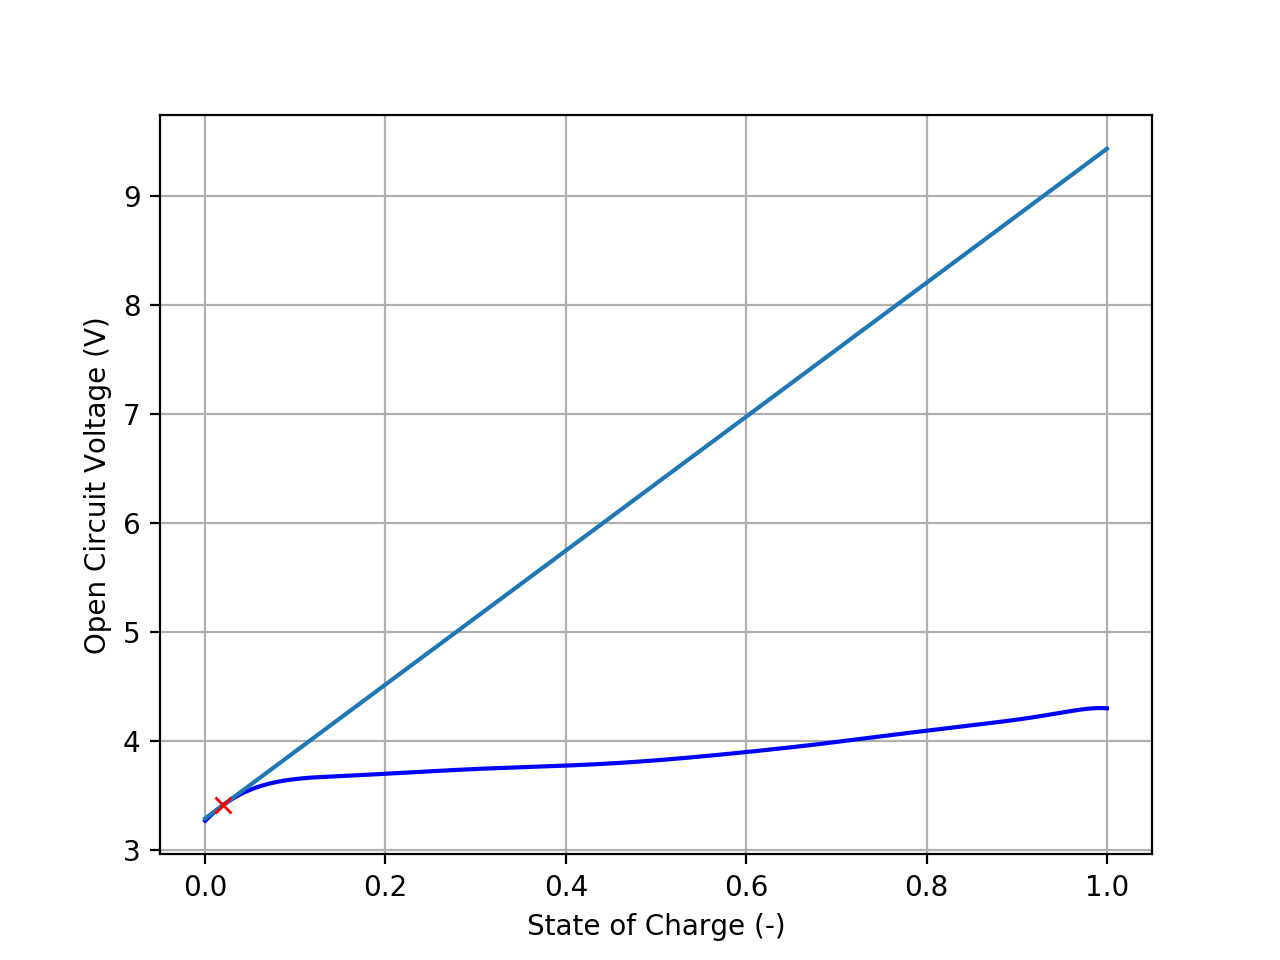

In [11]:
curve = OCVcurve('SOCvsOCV.csv')
curve.plot()
z0 = 0.02
a = curve.getslope(z0)
b = curve.OCVfromSOC(z0)-a*z0
x = np.array([0,1])
plt.plot(a*x+b)
plt.plot(z0,curve.OCVfromSOC(z0),'rx')

# Simulation

### Import the test file

In [13]:
#folder = '/home/lucas/Documents/Log_Analysis/Logs'
folder = '/Users/Lucas/Documents/Travail/Yuneec/Logs'
log_file = analog.pathfromQGC(folder,index=39)

print(log_file)
info = analog.logextract(log_file,'battery_status')

current = info['battery_current']
time = info['time_bs']
voltage = info['battery_voltage']/4

/Users/Lucas/Documents/Travail/Yuneec/Logs/log_39_2019-8-27-14-22-40.ulg


### Tune some more simulation parameters

In [14]:
Q = 6600*3.6 # has to be in Coulombs
eta = 0.99
z0 = curve.SOCfromOCV(np.mean(voltage[0])+R0*current[0]) # taken from log to be tested
battery = Thevenin(z0,Q,curve,R0,R1,C1)

In [15]:
print(f'True measured initital voltage is {voltage[0]:.2f} V')
print(f'True initial OCV would then be {voltage[0]+R0*current[0]:.2f} V, because initial current is {current[0]:.2f} A')

True measured initital voltage is 3.72 V
True initial OCV would then be 3.72 V, because initial current is 0.00 A


### Run the simulation using the state-space model

<IPython.core.display.Javascript object>


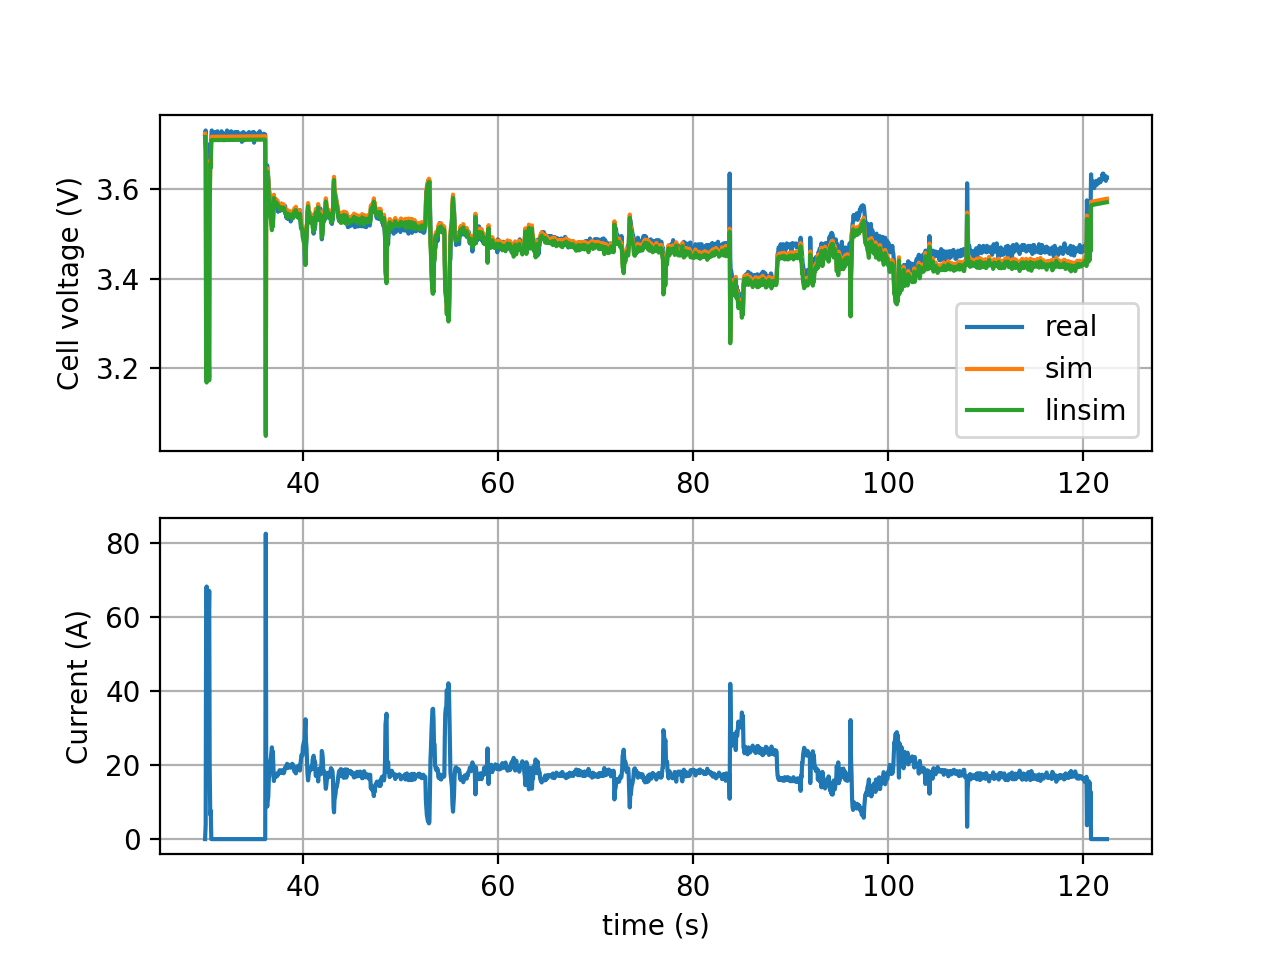

In [33]:
%matplotlib notebook
vsim = battery.simulate(time,current,curve,plot=False)
battery.statespace(np.mean(np.diff(time)))
vlsim = battery.lsim(time,current,curve)

plt.figure()
plt.subplot(211)
plt.plot(time,voltage,label='real')
plt.plot(time,vsim,label='sim')
plt.plot(time,vlsim+3.6,label='linsim')
plt.legend()
plt.grid()
plt.ylabel('Cell voltage (V)')
plt.subplot(212)
plt.plot(time,current)
plt.xlabel('time (s)')
plt.ylabel('Current (A)')
plt.grid()
plt.show()

In [18]:
N = len(vsim)
rmserror = (1/N*np.sum((vsim-voltage)**2))**.5
print(f'Root mean square error is {round(rmserror*1000,2)} mV. It is acceptable under 10mV according to Prof. G.Plett.')

Root mean square error is 34.72 mV. It is acceptable under 10mV according to Prof. G.Plett.


<IPython.core.display.Javascript object>


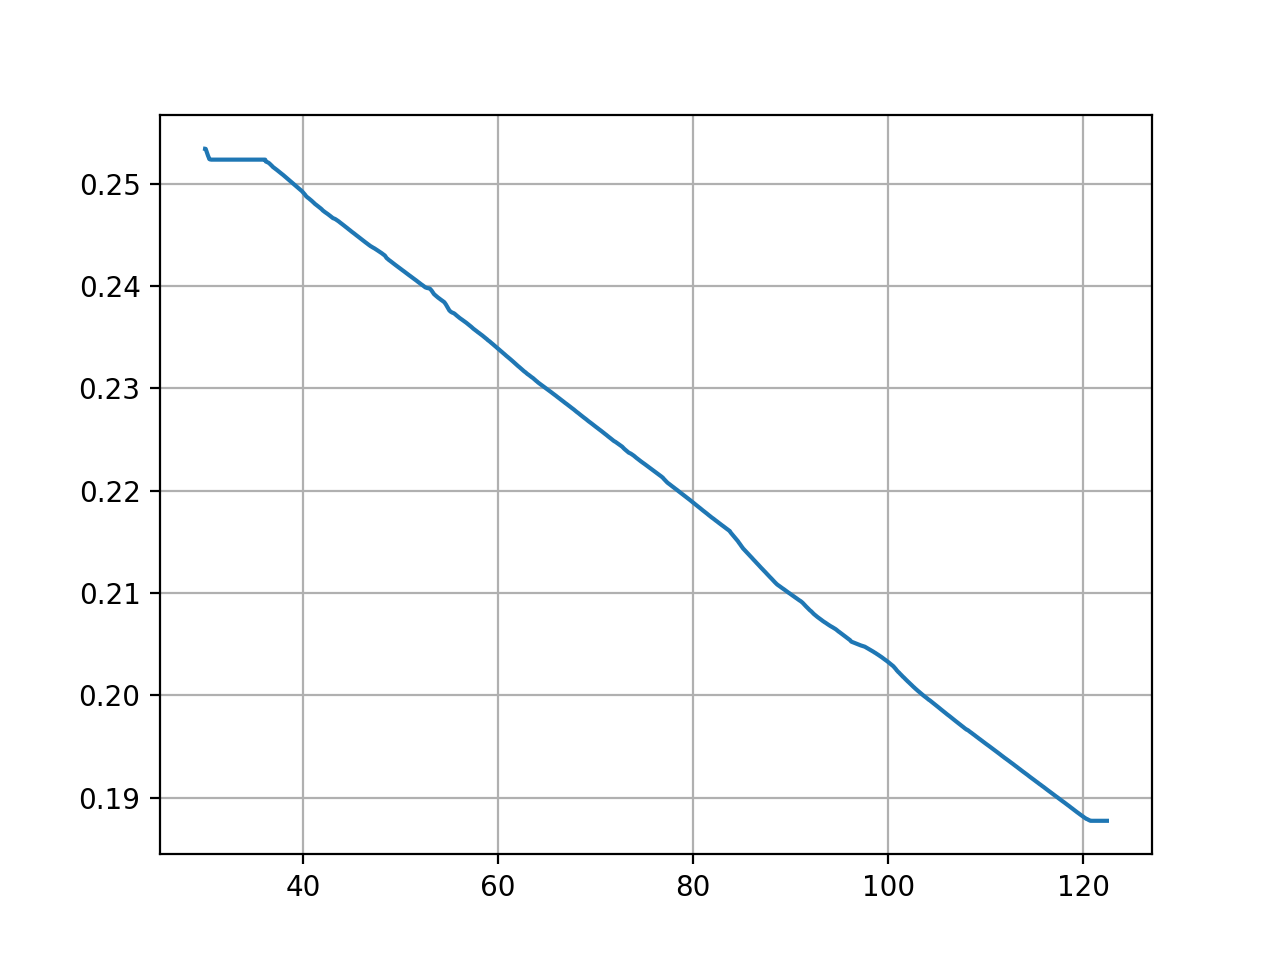

In [19]:
plt.figure()
plt.plot(time,battery.simz[1:])
plt.grid()

<IPython.core.display.Javascript object>


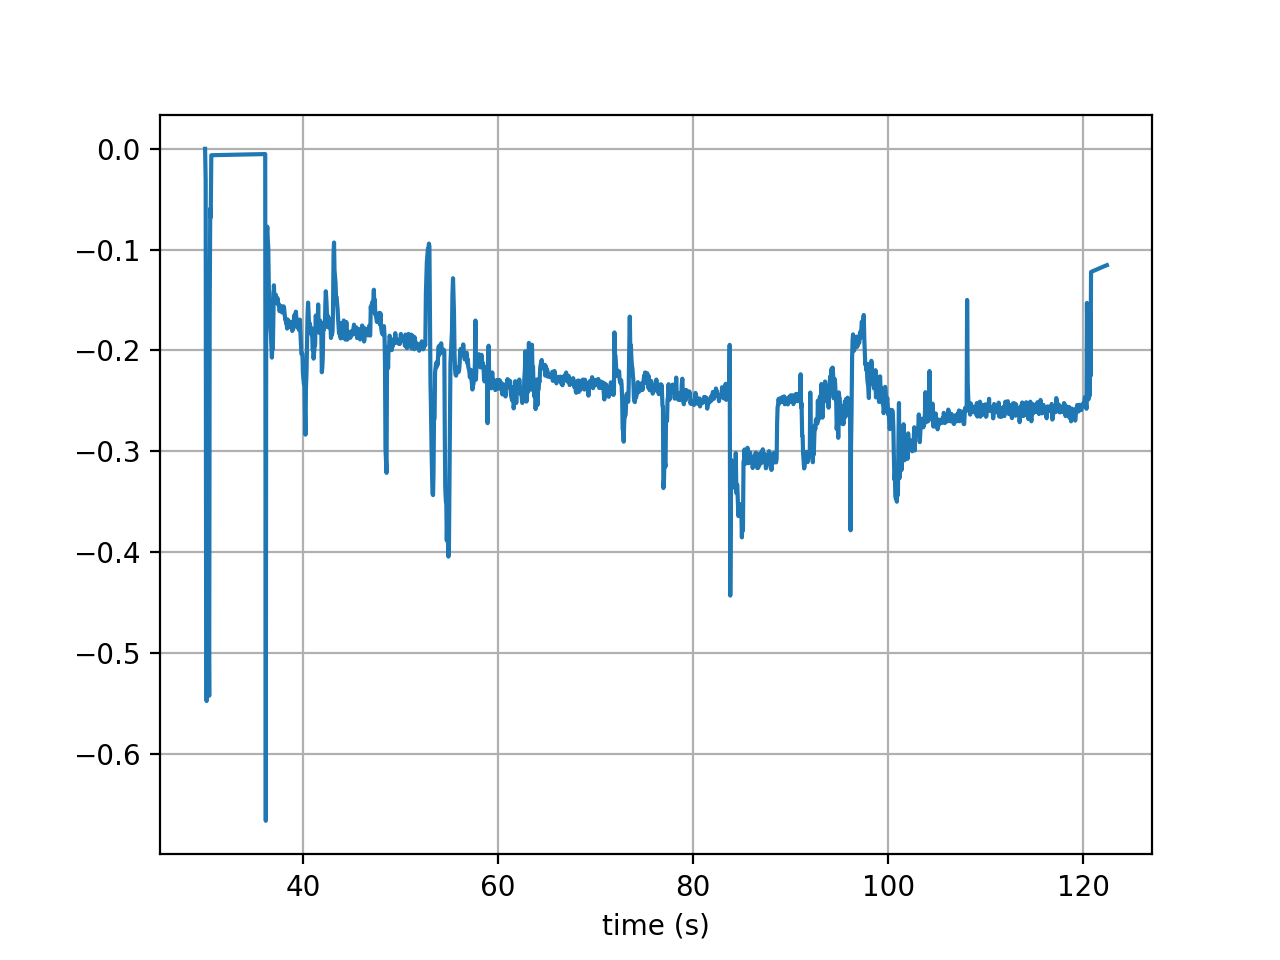

In [20]:
vtilda = vsim - curve.OCVfromSOC(battery.simz[1:])

plt.figure()
plt.plot(time,vtilda)
plt.xlabel('time (s)')
# plt.ylabel('v_{load}-OCV', usetex=True)
plt.grid()
plt.show()

# Kalman Filter

In [21]:
import filterpy
from filterpy.kalman import KalmanFilter

In [22]:
dim_x = 2 # number of states
dim_z = 1 # number of outputs
kf = KalmanFilter(2,1)
battery.statespace(battery.simdt)
kf.F = battery.A 
kf.B = battery.B 

In [81]:
xplus0 = np.array([[z0],[0.]]) # is a stack of 2x1 arrays = a 2xk array
covxplus0 = np.array([[1.,0.],[0., 1.]]) # is a stack of 2x2 arrays

covw = np.array([[1., 0.],[0., .5]]) # is a constant 2x2 array
covv = 0.5017 # is a constant 1x1 array

xminus = np.array([]) # is a stack of 2x1 arrays = a 2xk array
covmxminus = np.array([]) # is a stack of 2x2 arrays
yhat = np.array([]) # is a stack of 1x1 arrays = a 1-D array
xplus = np.array([]) # is a stack of 2x1 arrays = a 2xk array
covxplus = np.array([]) # is a stack of 2x2 arrays
L = np.array([]) # is a stack of stack of 2x1 arrays = a 1-D array

u = current # is a stack of 1x1 arrays = a 1-D array
y = vsim # is a stack of 1x1 arrays = a 1-D array

kfbat = Thevenin(z0,Q,curve,R0,R1,C1)

In [82]:
for k in range(len(y[:10])):
    print(f'\n New iteration k={k}')
    
    #if k==0:
        #print(f'Real value of z : {battery.simz[k]}, a posteriori estimated value of z : {xplus0[0]}')
        #print(f'Real value of i1 : {battery.simi1[k]}, a posteriori estimated value of i1 : {xplus0[1]}')
    #else:
        #print(f'Real value of z : {battery.simz[k]}, a posteriori estimated value of z : {xplus[0,-1]}')
        #print(f'Real value of i1 : {battery.simi1[k]}, a posteriori estimated value of i1 : {xplus[1,-1]}')
    
    if k == 0: 
        kfbat.reset(R0,R1,C1,xplus0[0])
    else: 
        kfbat.reset(R0,R1,C1,xplus[0,-1])
    kfbat.statespace(battery.simdt)
    
    
    #print(f'Matrix C is {kfbat.C}')
    
    
    # 1 : Prediction update
    
    # 1a State prediction
    
    if k==0: 
        alpha = np.reshape(kfbat.A@xplus0,(2,1))
        beta = kfbat.B*u[k]
        xminus = alpha + beta
    else : 
        alpha = np.reshape(kfbat.A@xplus[:,k-1],(2,1))
        beta = kfbat.B*u[k]
        xminus = np.concatenate([xminus, alpha + beta],axis=1)
    
    
    #if k==0:
        #print(f'Real value of z : {battery.simz[k]}, a priori estimated value of z : {xplus0[0]}')
        #print(f'Real value of i1 : {battery.simi1[k]}, a priori estimated value of i1 : {xplus0[1]}')
    #else:
        #print(f'Real value of z : {battery.simz[k]}, a priori estimated value of z : {xplus[0,-1]}')
        #print(f'Real value of i1 : {battery.simi1[k]}, a priori estimated value of i1 : {xplus[1,-1]}')
    
    
    #print(f'xminus is {np.shape(xminus)}, should be 2x{k+1}')
    
    kfbat.reset(R0,R1,C1,xminus[0,-1])
    kfbat.statespace(battery.simdt)
    
    
    # 1b State covariance a priori
    
    if k==0 :
        covxminus = kfbat.A@covxplus0@kfbat.A.T + covw
    elif k==1: 
        covxminus = np.dstack([covxminus,kfbat.A@covxplus@kfbat.A.T + covw])
    else :
        covxminus = np.dstack([covxminus,kfbat.A@covxplus[:,:,-1]@kfbat.A.T + covw])
        
    #print(f'covxminus is {np.shape(covxminus)}, should be 2x2x{k+1}')
    
    # 1c : Output predicition
    
    if k==0: 
        yhat = kfbat.OCVcurve.OCVfromSOC(xminus[0,k]) - R1*xminus[1,k] + kfbat.D*u[k]
    else : 
        yhat = np.concatenate([yhat,kfbat.OCVcurve.OCVfromSOC(xminus[0,k]) - R1*xminus[1,k] + kfbat.D*u[k]]) 
    #print(f'y : {y[k]}')  
    #print(f'yhat : {yhat[k]}')
    #print(f'yhat is {np.shape(yhat)}, should be {k+1}')
    
    # 2 : Measurement update
    
    # 2a Kalman gain computation
    
    if k==0:
        covxy = np.reshape(covxminus@kfbat.C.T,(2,1))
        covy = kfbat.C@covxminus@kfbat.C.T + covv
        L = covxy/covy
    else : 
        covxy = np.reshape(covxminus[:,:,-1]@kfbat.C.T,(2,1))
        covy = kfbat.C@covxminus[:,:,-1]@kfbat.C.T + covv
        L = np.concatenate([L,covxy/covy],axis=1)
    print(f'Lk={np.reshape(L[:,-1],(2,1))}')
    
    #print(f'L is {np.shape(L)}, should be 2x{k+1}')
          
    # 2b State estimate correction
          
    inno = y[k] - yhat[k]
    print(f'Innovation : {inno}')
    
    if k==0:
        xplus = xplus0  
    else : 
        xplus = np.concatenate([xplus,np.reshape(xminus[:,-1],(2,1)) + np.reshape(L[:,-1]*inno,(2,1))],axis=1) 
    #print(f'xplus is {np.shape(xplus)}, should be 2x{k+1}')
    
    # 2c State covariance a posteriori 
    if k==0: 
          covxplus = covxminus - L*kfbat.C@covxminus
    else :
        covxplus = np.dstack([covxplus,covxminus[:,:,-1] - L[:,-1]*kfbat.C@covxminus[:,:,-1]])
        #print(covxplus[:,:,k])
    #print(f'covxplus is {np.shape(covxplus)}, should be 2x2x{k+1}')    
    


 New iteration k=0
Lk=[[ 0.99417294]
 [-0.0117913 ]]
Innovation : 0.0

 New iteration k=1
Lk=[[ 1.01803965]
 [-0.01012479]]
Innovation : 5.69620908836832e-05

 New iteration k=2
Lk=[[ 1.02133716]
 [-0.48288931]]
Innovation : 0.0008785191024749395

 New iteration k=3
Lk=[[ 1.02132811]
 [-0.95435882]]
Innovation : 0.0005406677134098814

 New iteration k=4
Lk=[[ 1.02278191]
 [-1.41455045]]
Innovation : 0.00017411572931180785

 New iteration k=5
Lk=[[ 1.02610664]
 [-1.8607075 ]]
Innovation : 9.351277615854414e-05

 New iteration k=6
Lk=[[ 1.03116041]
 [-2.29131279]]
Innovation : 0.00010389153958856312

 New iteration k=7
Lk=[[ 1.0379071 ]
 [-2.70472722]]
Innovation : -5.1212554458057724e-05

 New iteration k=8
Lk=[[ 1.04623208]
 [-3.09991262]]
Innovation : 0.00010478322810758556

 New iteration k=9
Lk=[[ 1.05573362]
 [-3.47719159]]
Innovation : -0.0006327901119318469


<IPython.core.display.Javascript object>


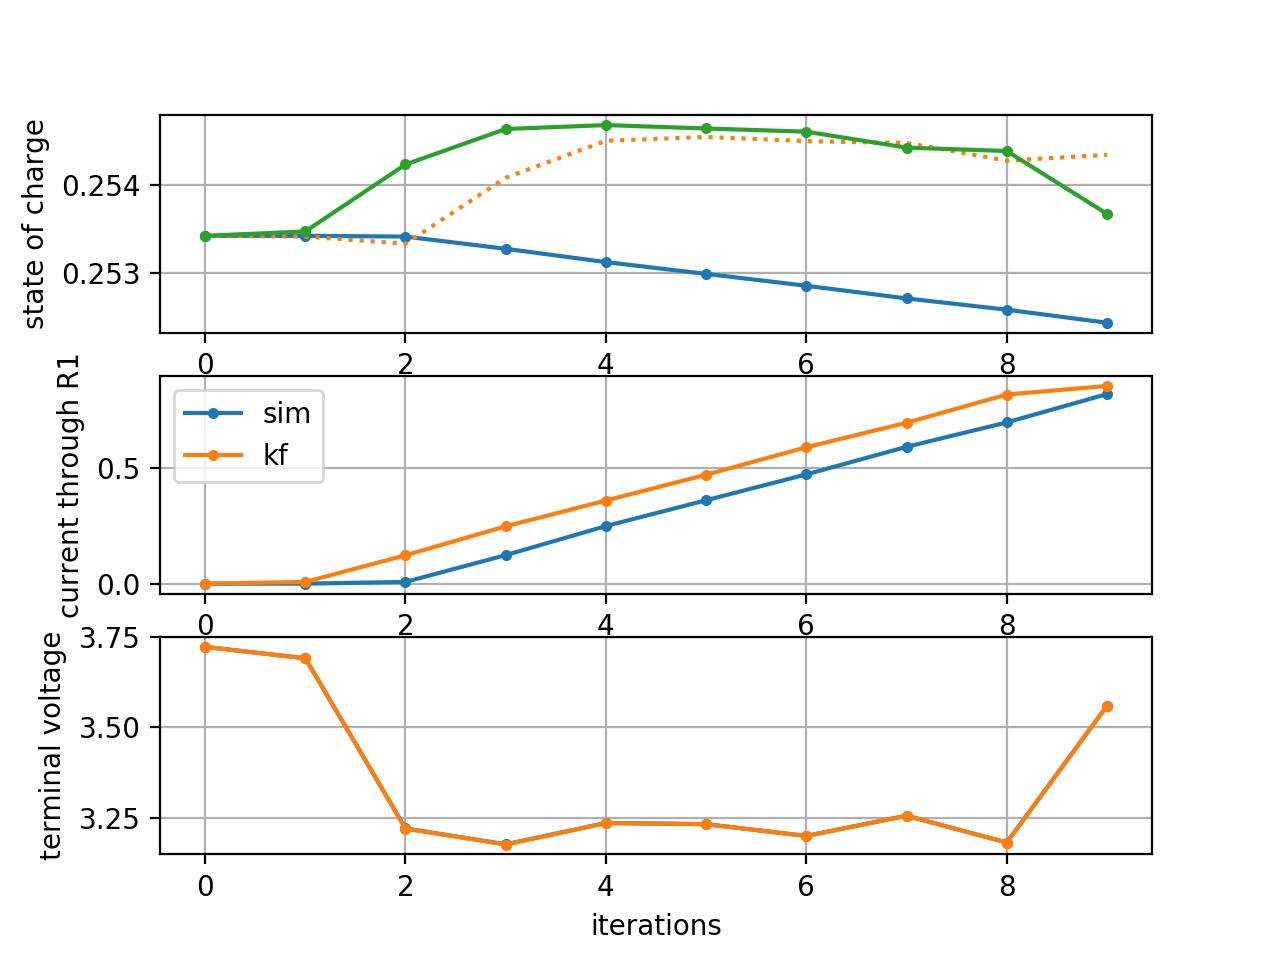

In [83]:
plt.figure()
plt.subplot(311)
plt.plot(battery.simz[:10],'.-')
plt.plot(xminus[0,:],':')
plt.plot(xplus[0,:],'.-')
plt.ylabel('state of charge')
plt.grid()
plt.subplot(312)
plt.plot(battery.simi1[:10],'.-',label='sim')
plt.plot(xplus[1,:],'.-',label='kf')
plt.legend()
plt.ylabel('current through R1')
plt.grid()
plt.subplot(313)
plt.plot(battery.simv[:10],'.-',label='sim')
plt.plot(yhat,'.-')
plt.xlabel('iterations')
plt.ylabel('terminal voltage')
plt.grid()

In [84]:
for k in range(3):
    print(f'k = {k}')
    print(f'covxminus = {np.linalg.eig(covxminus[:,:,k])}')
    print(f'covxplus = {np.linalg.eig(covxplus[:,:,k])}')

k = 0
covxminus = (array([2.        , 1.49631623]), array([[1., 0.],
       [0., 1.]]))
covxplus = (array([1.08973555, 1.49647481]), array([[-0.99964764, -0.02654408],
       [ 0.02654408, -0.99964764]]))
k = 1
covxminus = (array([2.0911769 , 1.98952186]), array([[ 0.99430399, -0.10658134],
       [ 0.10658134,  0.99430399]]))
covxplus = (array([1.12249254, 1.9792541 ]), array([[-0.66738504, -0.00649718],
       [-0.74471283, -0.99997889]]))
k = 2
covxminus = (array([2.13176535, 2.46266712]), array([[-0.33905368, -0.01615394],
       [-0.94076703, -0.99986952]]))
covxplus = (array([1.12196647, 2.47515354]), array([[-0.5683053 ,  0.00423951],
       [-0.82281777, -0.99999101]]))


In [77]:
print(xminus[0,2])
print(battery.simz[2])
print(xminus[0,2]+L[0,2]*(y[2]-yhat[2]))

0.253333638787403
0.25341411662460106
0.2542308589424354


In [ ]:
curve.OCVfromSOC(battery.simz[0])

In [ ]:
curve.getslope(battery.simz[0])*battery.simz[0]+curve.OCVfromSOC()